## 1. Importar Librerías

In [5]:
import sys
import json
import torch
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Agregar project root al path
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

from src.finetuning.hotspot_models import get_model

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 4070


## 2. Configuración

In [6]:
# Clases
class_names = ['no_hotspot', 'hotspot']

# Paths a los modelos entrenados
models_dir = project_root / 'models' / 'hotspot_classification'
efficientnet_path = models_dir / 'efficientnet_b0' / 'best_model.pth'
densenet_path = models_dir / 'densenet121' / 'best_model.pth'

# Cargar métricas de test
efficientnet_metrics_path = models_dir / 'efficientnet_b0' / 'test_metrics.json'
densenet_metrics_path = models_dir / 'densenet121' / 'test_metrics.json'

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Mostrar Métricas de Test

In [7]:
# Cargar y mostrar métricas de EfficientNet-B0
if efficientnet_metrics_path.exists():
    with open(efficientnet_metrics_path, 'r') as f:
        efficientnet_metrics = json.load(f)
    
    print("="*60)
    print("EFFICIENTNET-B0 - Test Metrics")
    print("="*60)
    print(json.dumps(efficientnet_metrics, indent=2))
else:
    print("⚠ EfficientNet-B0 metrics no encontradas")

print("\n")

# Cargar y mostrar métricas de DenseNet-121
if densenet_metrics_path.exists():
    with open(densenet_metrics_path, 'r') as f:
        densenet_metrics = json.load(f)
    
    print("="*60)
    print("DENSENET-121 - Test Metrics")
    print("="*60)
    print(json.dumps(densenet_metrics, indent=2))
else:
    print("⚠ DenseNet-121 metrics no encontradas")

EFFICIENTNET-B0 - Test Metrics
{
  "accuracy": 0.9325842696629213,
  "precision": 0.9460674157303371,
  "recall": 0.9325842696629213,
  "f1": 0.9346985622810197,
  "loss": 0.08976995582127253,
  "confusion_matrix": [
    [
      24,
      0
    ],
    [
      6,
      59
    ]
  ]
}


DENSENET-121 - Test Metrics
{
  "accuracy": 0.9438202247191011,
  "precision": 0.9448174157303372,
  "recall": 0.9438202247191011,
  "f1": 0.9441757366651914,
  "loss": 0.04482666267019309,
  "confusion_matrix": [
    [
      22,
      2
    ],
    [
      3,
      62
    ]
  ]
}


## 4. Cargar Modelos Entrenados

In [8]:
# Cargar EfficientNet-B0
print("Cargando EfficientNet-B0...")
efficientnet_model = get_model('efficientnet_b0', num_classes=len(class_names), pretrained=False)
checkpoint = torch.load(efficientnet_path, map_location=device)
efficientnet_model.load_state_dict(checkpoint['model_state_dict'])
efficientnet_model = efficientnet_model.to(device)
efficientnet_model.eval()
print(f"✓ EfficientNet-B0 cargado (Accuracy: {checkpoint['best_val_acc']:.4f})")

# Cargar DenseNet-121
print("\nCargando DenseNet-121...")
densenet_model = get_model('densenet121', num_classes=len(class_names), pretrained=False)
checkpoint = torch.load(densenet_path, map_location=device)
densenet_model.load_state_dict(checkpoint['model_state_dict'])
densenet_model = densenet_model.to(device)
densenet_model.eval()
print(f"✓ DenseNet-121 cargado (Accuracy: {checkpoint['best_val_acc']:.4f})")

Cargando EfficientNet-B0...
✓ EfficientNet-B0 cargado (Accuracy: 0.9831)

Cargando DenseNet-121...
✓ DenseNet-121 cargado (Accuracy: 0.9831)
✓ DenseNet-121 cargado (Accuracy: 0.9831)


## 5. Definir Transformaciones

In [9]:
# Transformaciones (ambos modelos usan 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 6. Función de Predicción

In [10]:
def predict_hotspot(image_path, show_image=True):
    """
    Predice si una imagen tiene hotspots usando ambos modelos.
    
    Args:
        image_path: Path a la imagen
        show_image: Si True, muestra la imagen y predicciones
    
    Returns:
        dict con predicciones de ambos modelos
    """
    # Cargar imagen
    image = Image.open(image_path).convert('RGB')
    
    # Preparar input
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predicción con EfficientNet-B0
    with torch.no_grad():
        efficientnet_output = efficientnet_model(input_tensor)
        efficientnet_probs = F.softmax(efficientnet_output, dim=1)
        efficientnet_pred_idx = torch.argmax(efficientnet_probs, dim=1).item()
        efficientnet_confidence = efficientnet_probs[0, efficientnet_pred_idx].item()
    
    # Predicción con DenseNet-121
    with torch.no_grad():
        densenet_output = densenet_model(input_tensor)
        densenet_probs = F.softmax(densenet_output, dim=1)
        densenet_pred_idx = torch.argmax(densenet_probs, dim=1).item()
        densenet_confidence = densenet_probs[0, densenet_pred_idx].item()
    
    results = {
        'efficientnet_b0': {
            'class': class_names[efficientnet_pred_idx],
            'confidence': efficientnet_confidence,
            'probabilities': {
                'no_hotspot': efficientnet_probs[0, 0].item(),
                'hotspot': efficientnet_probs[0, 1].item()
            }
        },
        'densenet121': {
            'class': class_names[densenet_pred_idx],
            'confidence': densenet_confidence,
            'probabilities': {
                'no_hotspot': densenet_probs[0, 0].item(),
                'hotspot': densenet_probs[0, 1].item()
            }
        }
    }
    
    if show_image:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Mostrar imagen original
        axes[0].imshow(image)
        axes[0].axis('off')
        axes[0].set_title(f'Imagen Térmica\n{Path(image_path).name}', fontsize=12, fontweight='bold')
        
        # EfficientNet-B0 probabilities
        eff_classes = list(results['efficientnet_b0']['probabilities'].keys())
        eff_probs = list(results['efficientnet_b0']['probabilities'].values())
        colors_eff = ['green' if results['efficientnet_b0']['class'] == 'hotspot' else 'blue',
                      'red' if results['efficientnet_b0']['class'] == 'hotspot' else 'lightblue']
        axes[1].bar(eff_classes, eff_probs, color=colors_eff)
        axes[1].set_ylabel('Probabilidad', fontsize=10)
        axes[1].set_title(f"EfficientNet-B0\nPredicción: {results['efficientnet_b0']['class']}\nConfianza: {results['efficientnet_b0']['confidence']:.2%}", 
                         fontsize=12, fontweight='bold')
        axes[1].set_ylim([0, 1])
        axes[1].grid(axis='y', alpha=0.3)
        
        # DenseNet-121 probabilities
        dense_classes = list(results['densenet121']['probabilities'].keys())
        dense_probs = list(results['densenet121']['probabilities'].values())
        colors_dense = ['green' if results['densenet121']['class'] == 'hotspot' else 'blue',
                        'red' if results['densenet121']['class'] == 'hotspot' else 'lightblue']
        axes[2].bar(dense_classes, dense_probs, color=colors_dense)
        axes[2].set_ylabel('Probabilidad', fontsize=10)
        axes[2].set_title(f"DenseNet-121\nPredicción: {results['densenet121']['class']}\nConfianza: {results['densenet121']['confidence']:.2%}", 
                         fontsize=12, fontweight='bold')
        axes[2].set_ylim([0, 1])
        axes[2].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return results

## 7. Ejemplos de Inferencia

### 7.1 Listar imágenes disponibles

In [11]:
# Directorio de imágenes anotadas
test_images_dir = project_root / 'data' / 'processed' / 'hotspot_classification'

# Recopilar imágenes de muestra
sample_images = {'no_hotspot': [], 'hotspot': []}

for class_name in class_names:
    for equipment_dir in test_images_dir.iterdir():
        if equipment_dir.is_dir():
            class_dir = equipment_dir / class_name
            if class_dir.exists():
                images = list(class_dir.glob('*.jpg'))[:2]
                sample_images[class_name].extend(images)

print(f"Imágenes sin hotspot: {len(sample_images['no_hotspot'])}")
print(f"Imágenes con hotspot: {len(sample_images['hotspot'])}")

print("\nEjemplos de imágenes sin hotspot:")
for i, img in enumerate(sample_images['no_hotspot'][:3]):
    print(f"  {i+1}. {img.parent.parent.name}/{img.name}")

print("\nEjemplos de imágenes con hotspot:")
for i, img in enumerate(sample_images['hotspot'][:3]):
    print(f"  {i+1}. {img.parent.parent.name}/{img.name}")

Imágenes sin hotspot: 10
Imágenes con hotspot: 10

Ejemplos de imágenes sin hotspot:
  1. Circuit_Breakers/FLIR4534.jpg
  2. Circuit_Breakers/FLIR4288.jpg
  3. Power_Transformers/FLIR2248.jpg

Ejemplos de imágenes con hotspot:
  1. Circuit_Breakers/FLIR4430.jpg
  2. Circuit_Breakers/FLIR4480.jpg
  3. Power_Transformers/FLIR0588.jpg


### 7.2 Predecir imagen sin hotspot

Prediciendo imagen SIN hotspot: /home/santiagovasquez/vision_prj/data/processed/hotspot_classification/Circuit_Breakers/no_hotspot/FLIR4534.jpg



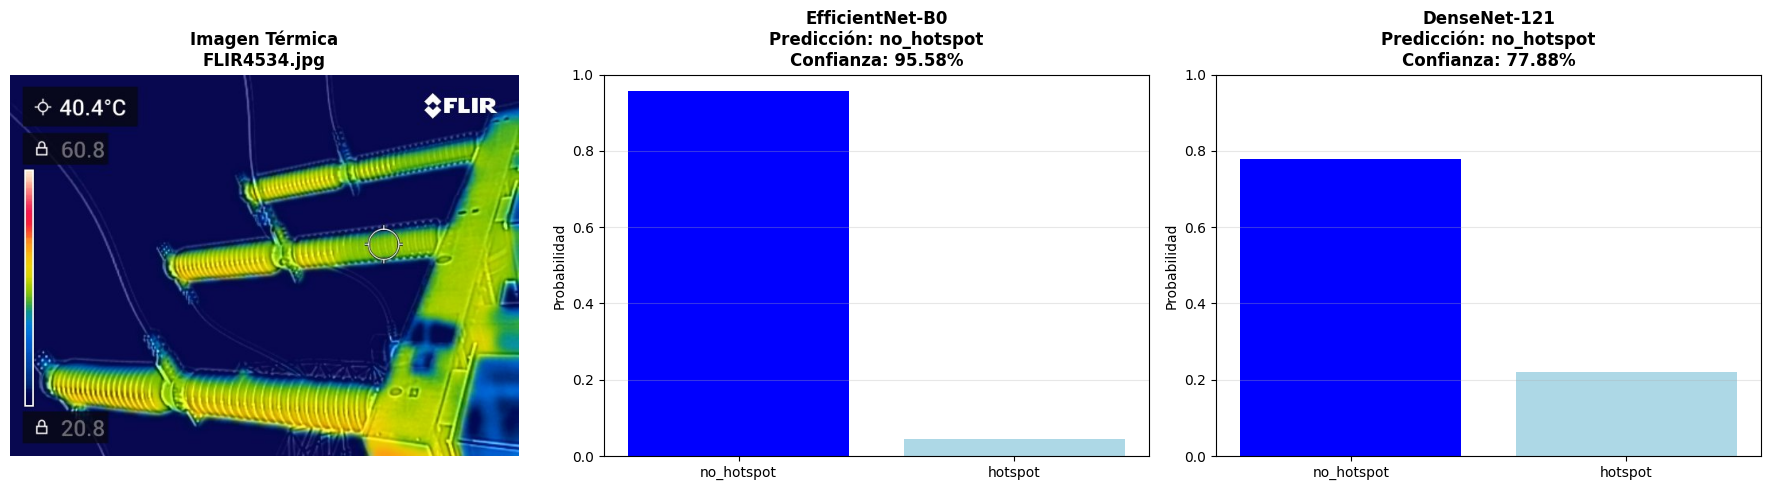


RESULTADOS

EfficientNet-B0: no_hotspot (95.58%)
DenseNet-121: no_hotspot (77.88%)


In [12]:
# Predecir una imagen sin hotspot
if sample_images['no_hotspot']:
    test_image = sample_images['no_hotspot'][0]
    print(f"Prediciendo imagen SIN hotspot: {test_image}\n")
    results = predict_hotspot(test_image)
    
    print("\n" + "="*60)
    print("RESULTADOS")
    print("="*60)
    print(f"\nEfficientNet-B0: {results['efficientnet_b0']['class']} ({results['efficientnet_b0']['confidence']:.2%})")
    print(f"DenseNet-121: {results['densenet121']['class']} ({results['densenet121']['confidence']:.2%})")
else:
    print("No hay imágenes sin hotspot disponibles")

### 7.3 Predecir imagen con hotspot

Prediciendo imagen CON hotspot: /home/santiagovasquez/vision_prj/data/processed/hotspot_classification/Circuit_Breakers/hotspot/FLIR4430.jpg



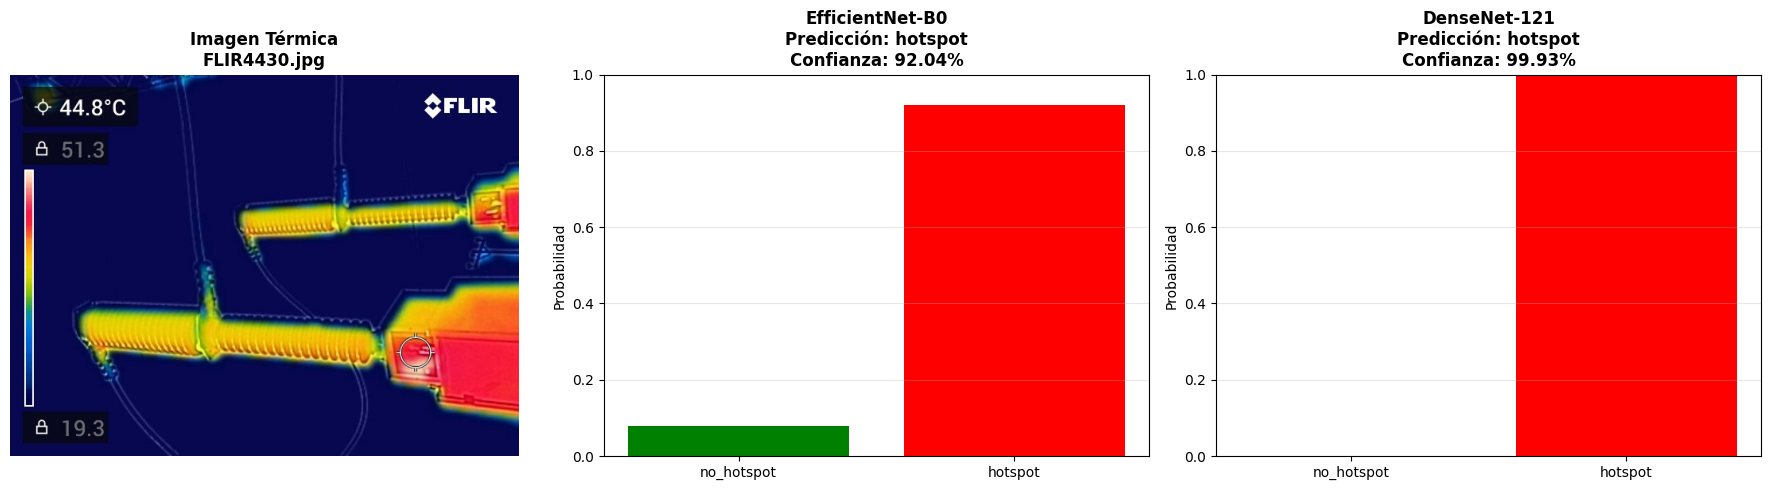


RESULTADOS

EfficientNet-B0: hotspot (92.04%)
DenseNet-121: hotspot (99.93%)


In [13]:
# Predecir una imagen con hotspot
if sample_images['hotspot']:
    test_image = sample_images['hotspot'][0]
    print(f"Prediciendo imagen CON hotspot: {test_image}\n")
    results = predict_hotspot(test_image)
    
    print("\n" + "="*60)
    print("RESULTADOS")
    print("="*60)
    print(f"\nEfficientNet-B0: {results['efficientnet_b0']['class']} ({results['efficientnet_b0']['confidence']:.2%})")
    print(f"DenseNet-121: {results['densenet121']['class']} ({results['densenet121']['confidence']:.2%})")
else:
    print("No hay imágenes con hotspot disponibles")

### 7.4 Predecir múltiples imágenes


PREDICCIÓN 1/4


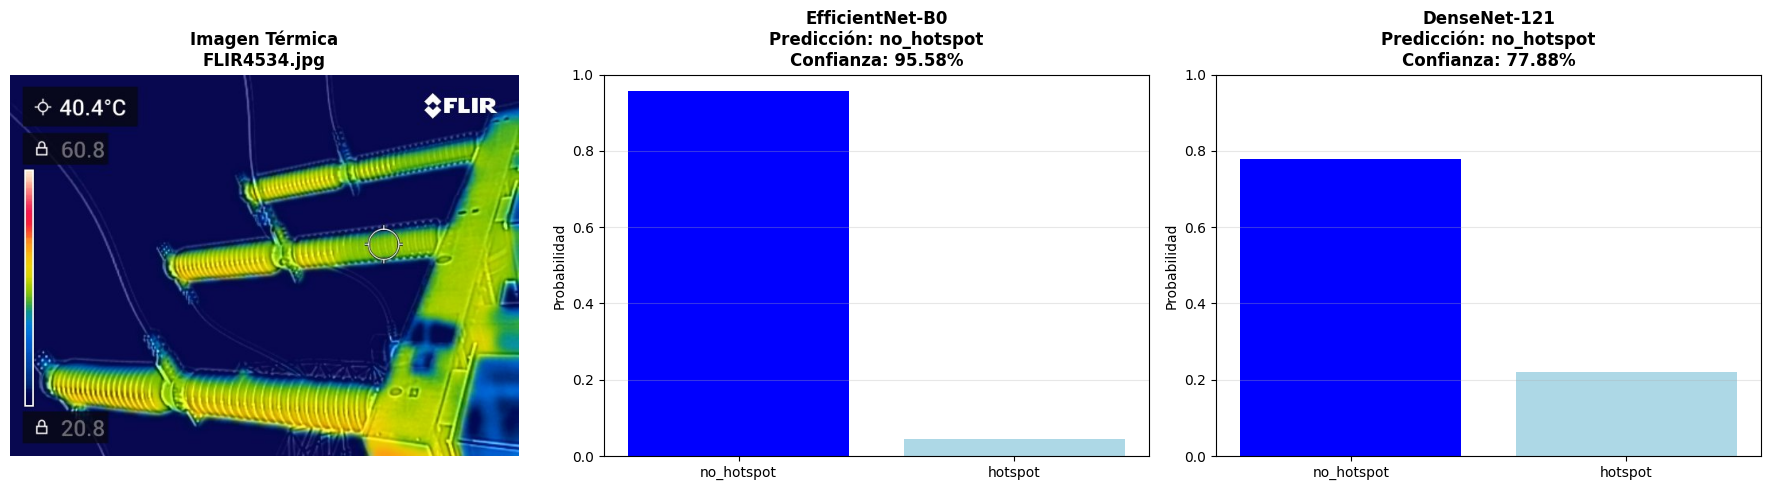


PREDICCIÓN 2/4


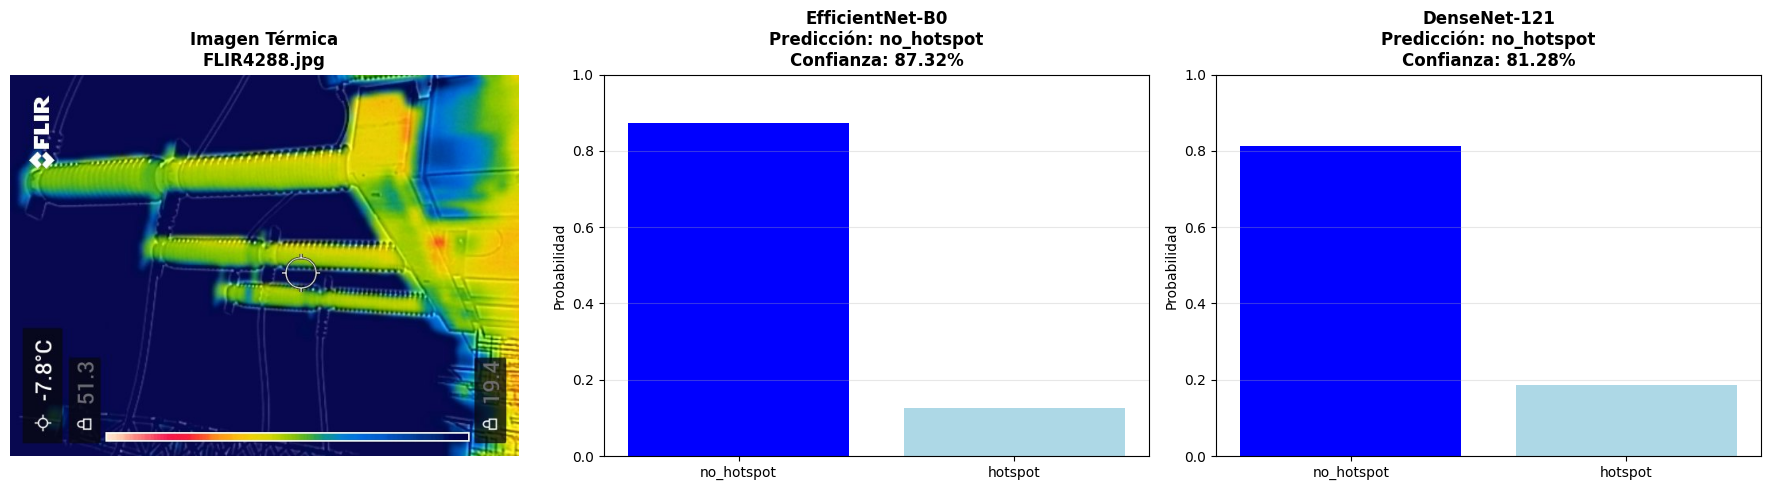


PREDICCIÓN 3/4


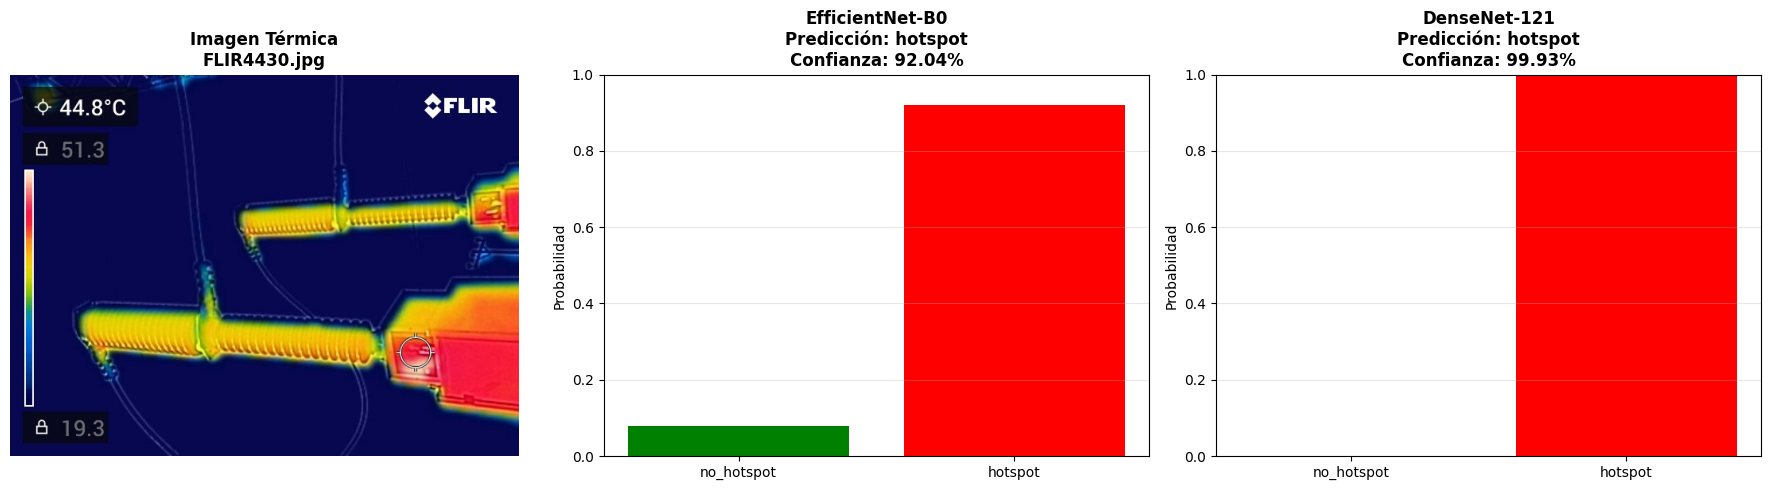


PREDICCIÓN 4/4


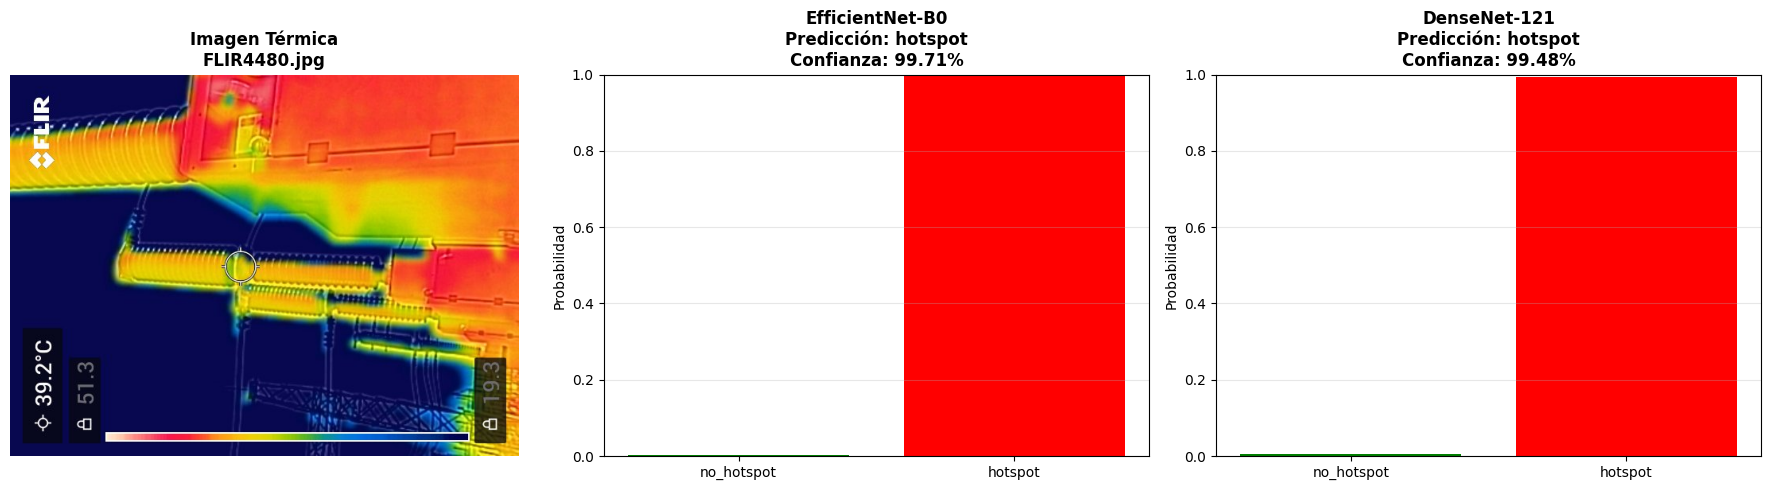

In [14]:
# Predecir varias imágenes de cada clase
all_samples = sample_images['no_hotspot'][:2] + sample_images['hotspot'][:2]

for i, img_path in enumerate(all_samples):
    print(f"\n{'='*80}")
    print(f"PREDICCIÓN {i+1}/{len(all_samples)}")
    print(f"{'='*80}")
    results = predict_hotspot(img_path)

### 7.5 Predecir desde una ruta personalizada

In [15]:
# Especificar ruta personalizada
custom_image_path = "ruta/a/tu/imagen_termica.jpg"  # Cambiar por la ruta de tu imagen

# Descomentar para usar:
# if Path(custom_image_path).exists():
#     results = predict_hotspot(custom_image_path)
# else:
#     print(f"Imagen no encontrada: {custom_image_path}")

## 8. Comparación de Modelos

In [16]:
# Evaluar acuerdo entre modelos
all_test_images = sample_images['no_hotspot'][:5] + sample_images['hotspot'][:5]
agreement_count = 0
correct_eff = 0
correct_dense = 0

print("Comparando predicciones de ambos modelos...\n")
print(f"{'Imagen':<35} {'Clase Real':<15} {'EfficientNet-B0':<20} {'DenseNet-121':<20} {'Acuerdo'}")
print("="*115)

for img_path in all_test_images:
    # Determinar clase real
    true_class = img_path.parent.name
    
    results = predict_hotspot(img_path, show_image=False)
    
    eff_pred = results['efficientnet_b0']['class']
    dense_pred = results['densenet121']['class']
    
    agree = "✓" if eff_pred == dense_pred else "✗"
    
    if eff_pred == dense_pred:
        agreement_count += 1
    
    if eff_pred == true_class:
        correct_eff += 1
    
    if dense_pred == true_class:
        correct_dense += 1
    
    equipment = img_path.parent.parent.name
    img_name = f"{equipment}/{img_path.name[:15]}"
    
    print(f"{img_name:<35} {true_class:<15} {eff_pred:<20} {dense_pred:<20} {agree}")

print("="*115)
print(f"\nAcuerdo entre modelos: {agreement_count}/{len(all_test_images)} ({agreement_count/len(all_test_images):.1%})")
print(f"EfficientNet-B0 correcto: {correct_eff}/{len(all_test_images)} ({correct_eff/len(all_test_images):.1%})")
print(f"DenseNet-121 correcto: {correct_dense}/{len(all_test_images)} ({correct_dense/len(all_test_images):.1%})")

Comparando predicciones de ambos modelos...

Imagen                              Clase Real      EfficientNet-B0      DenseNet-121         Acuerdo
Circuit_Breakers/FLIR4534.jpg       no_hotspot      no_hotspot           no_hotspot           ✓
Circuit_Breakers/FLIR4288.jpg       no_hotspot      no_hotspot           no_hotspot           ✓
Power_Transformers/FLIR2248.jpg     no_hotspot      no_hotspot           no_hotspot           ✓
Power_Transformers/FLIR2264.jpg     no_hotspot      no_hotspot           no_hotspot           ✓
Surge_Arresters/FLIR2796.jpg        no_hotspot      no_hotspot           no_hotspot           ✓
Circuit_Breakers/FLIR4430.jpg       hotspot         hotspot              hotspot              ✓
Circuit_Breakers/FLIR4480.jpg       hotspot         hotspot              hotspot              ✓
Power_Transformers/FLIR0588.jpg     hotspot         hotspot              hotspot              ✓
Power_Transformers/FLIR0520.jpg     hotspot         hotspot              hotspot     

## 9. Análisis por Tipo de Equipo

In [17]:
# Analizar predicciones por tipo de equipo
equipment_types = ['Circuit_Breakers', 'Disconnectors', 'Power_Transformers', 'Surge_Arresters', 'Wave_Traps']

print("\nAnálisis por tipo de equipo:\n")
print(f"{'Equipo':<25} {'Total':<10} {'EfficientNet Acc':<20} {'DenseNet Acc'}")
print("="*75)

for equipment in equipment_types:
    equipment_dir = test_images_dir / equipment
    if not equipment_dir.exists():
        continue
    
    # Recopilar imágenes de este equipo
    equipment_images = []
    for class_name in class_names:
        class_dir = equipment_dir / class_name
        if class_dir.exists():
            equipment_images.extend(list(class_dir.glob('*.jpg'))[:3])
    
    if not equipment_images:
        continue
    
    correct_eff = 0
    correct_dense = 0
    
    for img_path in equipment_images:
        true_class = img_path.parent.name
        results = predict_hotspot(img_path, show_image=False)
        
        if results['efficientnet_b0']['class'] == true_class:
            correct_eff += 1
        if results['densenet121']['class'] == true_class:
            correct_dense += 1
    
    total = len(equipment_images)
    eff_acc = correct_eff / total if total > 0 else 0
    dense_acc = correct_dense / total if total > 0 else 0
    
    print(f"{equipment:<25} {total:<10} {eff_acc:.1%} ({correct_eff}/{total}){'':<8} {dense_acc:.1%} ({correct_dense}/{total})")

print("="*75)


Análisis por tipo de equipo:

Equipo                    Total      EfficientNet Acc     DenseNet Acc
Circuit_Breakers          6          100.0% (6/6)         83.3% (5/6)
Disconnectors             6          100.0% (6/6)         100.0% (6/6)
Power_Transformers        6          100.0% (6/6)         100.0% (6/6)
Power_Transformers        6          100.0% (6/6)         100.0% (6/6)
Surge_Arresters           6          100.0% (6/6)         100.0% (6/6)
Surge_Arresters           6          100.0% (6/6)         100.0% (6/6)
Wave_Traps                6          100.0% (6/6)         100.0% (6/6)
Wave_Traps                6          100.0% (6/6)         100.0% (6/6)


## 10. Limpieza de GPU

In [18]:
# Liberar memoria GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✓ Cache de GPU limpiado")

✓ Cache de GPU limpiado
